# RL example:

In this example, we tune a model predictive control (MPC) controller that recursively solves the optimal control problem (OCP): 
\begin{align*}
\textbf{OCP}:\quad
\mathop{\textrm{argmin}}_{(x,u)}  
\ \ 
\sum_{t=0}^T 
x_t^\top Q^\theta x_t
+ 
\sum_{t=0}^{T-1} 
u_t^\top R^\theta x_t
\ \ \text{ s.t. }  \ \ 
x_{t+1}=f(x_t,u_t), 
\quad
x_0 = x_s, 
\end{align*}
where $\theta$ are trainable parameters that parameterize the quadratic costs:
$$
Q=\begin{bmatrix}\theta^1 & 0 & 0 \\ 0 & \theta^2 & 0 \\ 0 & 0 & \theta^3\end{bmatrix},
\quad
R=\begin{bmatrix}\theta^4 & 0 & 0 \\ 0 & \theta^5 & 0 \\ 0 & 0 & \theta^6\end{bmatrix}.
$$
The weights $\theta$ are trained via gradient descent on the RL problem:
$$
\max_\theta
\ 
\mathbb{E}\left[
\sum_{t=1}^H R(x_t, \pi^\theta(x_t))
\right],
\ \ 
x_{t+1}=\textrm{SimEnv}(x_t,\pi^\theta(x_t)),
\ \ 
x_0\sim\mathcal{D}_{\text{initial states}},
$$
where $\pi^\theta(x_t)$ is the first control of the MPC solution to OCP with initial state $x_t$, and $R$ is the reward function
$$
R(x,u)=-(10\|x\|^2+\|u\|^2).
$$

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import time

import matplotlib.pyplot as plt
from jax import config

config.update("jax_enable_x64", True)  # use double precision

import jax
import jax.numpy as jnp
from jax import jit, vmap

from diffmpc.dynamics.spacecraft_dynamics import SpacecraftDynamics
from diffmpc.problems.optimal_control_problem import OptimalControlProblem
from diffmpc.solvers.sqp import SQPSolver
from diffmpc.utils.load_params import (
    load_problem_params,
    load_solver_params,
)

### RL: Define domain randomization & reward

In [3]:
"""Utilities"""
import numpy as np

def generate_problem_data(batch_size, seed):
    """Generate spacecraft problem data for benchmarking"""
    np.random.seed(seed)
    min_inertia = 1.0
    max_inertia = 10.0
    inertia_vector = min_inertia + np.random.rand(3) * (max_inertia - min_inertia)
    min_state = -0.1
    max_state = 0.1
    initial_states = min_state + np.random.rand(batch_size, 3) * (max_state - min_state)
    return jnp.array(inertia_vector), jnp.array(initial_states)

def reward(state, control):
    r = -(1e1 * jnp.sum(state**2) + jnp.sum(control**2))
    return r

### Define problem and solver parameters

In [4]:
batch_size = 2
horizon = 40
num_sim_steps = 20
num_steps = 10  # num training steps
lr = 1.0  # learning rate

# Problem parameters
inertia_vector, initial_states = generate_problem_data(batch_size, seed=0)
print(f"device: {inertia_vector.device}")

problem_params = load_problem_params("spacecraft.yaml")
diffmpc_horizon = horizon - 1  # diffmpc horizon is N+1
problem_params["horizon"] = diffmpc_horizon
problem_params["inertia_vector"] = inertia_vector
problem_params["reference_state_trajectory"] = jnp.zeros((diffmpc_horizon + 1, 3))
problem_params["reference_control_trajectory"] = jnp.zeros((diffmpc_horizon + 1, 3))
problem_params["weights_penalization_final_state"] = jnp.zeros(3)

# Solver parameters
solver_params = load_solver_params("sqp.yaml")
solver_params["num_scp_iteration_max"] = 1
solver_params["pcg"]["tol_epsilon"] = 1.0e-12
solver_params["linesearch"] = True
solver_params["linesearch_alphas"] = [1.0]

device: TFRT_CPU_0


In [5]:
dynamics = SpacecraftDynamics()
problem = OptimalControlProblem(dynamics=dynamics, params=problem_params)
solver = SQPSolver(program=problem, params=solver_params)

def solver_initial_guess(initial_state):
    params = {**problem_params, "initial_state": initial_state}
    return solver.initial_guess(params)

# trainable parameters
weights = {
    k: problem_params[k]
    for k in [
        "weights_penalization_reference_state_trajectory",
        "weights_penalization_control_squared",
    ]
}
problem_params["initial_state"] = initial_states[0]

#### Solution with nominal MPC parameters before RL 

In [6]:
### Solve the problem with nominal MPC parameters (pre-RL)
solution_baseline = solver.solve(
    solver.initial_guess(problem_params), problem_params, weights
)

### RL training functions

In [7]:
def rollout(state, weights):
    initial_carry = (state, solver_initial_guess(state), 0.0)

    def rollout_step(carry, _):
        state, solution, running_reward = carry

        # Solve MPC problem
        params = {
            **problem_params,
            "inertia_vector": inertia_vector,
            "initial_state": state,
        }
        solution = solver.solve(solution, params, weights)
        control = solution.controls[0]

        # Simulate forward
        dt = params["discretization_resolution"]
        next_state = state + dt * dynamics.state_dot(state, control, params)
        running_reward = running_reward + reward(next_state, control)

        return (next_state, solution, running_reward), None

    final_carry, _ = jax.lax.scan(
        rollout_step, initial_carry, None, length=num_sim_steps
    )
    _, _, final_reward = final_carry
    return final_reward

rollout_batch = vmap(rollout, in_axes=(0, None))

def rollout_for_grad(weights):
    return jnp.sum(rollout_batch(initial_states, weights))

@jit
def grad_step_and_loss(weights):
    loss, grad = jax.value_and_grad(rollout_for_grad)(weights)
    for key in weights.keys():
        weights[key] = jnp.maximum(
            1e-10, weights[key] + lr * jnp.nan_to_num(grad[key])
        )
    return weights, loss

jax.block_until_ready(grad_step_and_loss(weights))

({'weights_penalization_control_squared': Array([0.9955808, 0.9085766, 0.8319815], dtype=float64),
  'weights_penalization_reference_state_trajectory': Array([1.0033015 , 1.09093417, 1.16958629], dtype=float64)},
 Array(-2.8196996, dtype=float64))

### RL training loop

In [8]:
print(
    "Pre-RL state cost weight =",
    weights["weights_penalization_reference_state_trajectory"],
)
s = time.monotonic()
for step in range(num_steps):
    weights, loss = grad_step_and_loss(weights)
    jax.block_until_ready((weights, loss))
    ts = time.monotonic() - s
    print(f"Step {1+step}/{num_steps}, reward: {loss}, time: {ts}")

print(
    f"Training elapsed ms {1000*ts/(batch_size*num_sim_steps*num_steps):.3f} per"
    " step/problem/trainingstep"
)
print(
    "Post-RL state cost weight =",
    weights["weights_penalization_reference_state_trajectory"],
)

Pre-RL state cost weight = [1. 1. 1.]
Step 1/10, reward: -2.8196995973193135, time: 0.019034573997487314
Step 2/10, reward: -2.7473615938094436, time: 0.03766192701004911
Step 3/10, reward: -2.669627804934467, time: 0.062386896010139026
Step 4/10, reward: -2.6046548615121488, time: 0.084652374003781
Step 5/10, reward: -2.5825462084746866, time: 0.10187460800807457
Step 6/10, reward: -2.5769316128586888, time: 0.12089165800716728
Step 7/10, reward: -2.5665943568064944, time: 0.1387936510000145
Step 8/10, reward: -2.5795536943998916, time: 0.1597520630020881
Step 9/10, reward: -2.5668477676991954, time: 0.17674699700728524
Step 10/10, reward: -2.581544004508397, time: 0.19339213499915786
Training elapsed ms 0.483 per step/problem/trainingstep
Post-RL state cost weight = [1.03660589 1.38610228 1.4784903 ]


#### Plot and compare solutions pre- and post-RL

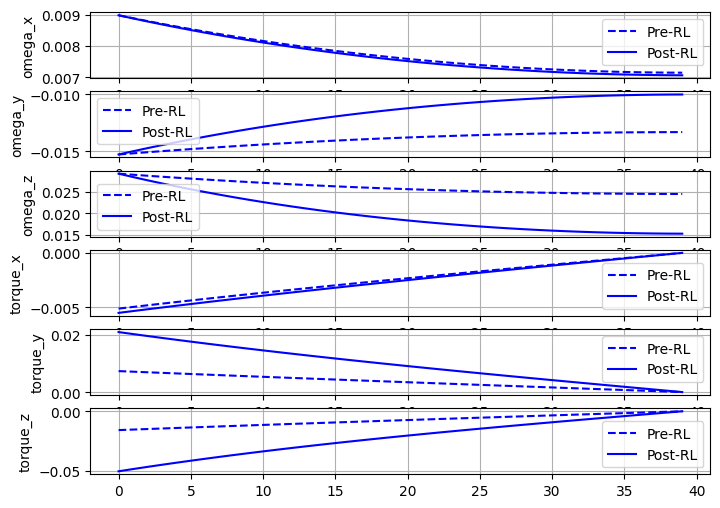

In [9]:
# plot rollouts with learned weights (post-RL)
solution = solver.solve(
    solver.initial_guess(problem_params), problem_params, weights
)

# plot rollouts with base weights (pre-RL)
fig, axes = plt.subplots(
    nrows=dynamics.num_states + dynamics.num_controls, figsize=(8, 6)
)
for i, ax in enumerate(axes.flatten()):
    if i < dynamics.num_states:
        ax.plot(solution_baseline.states[:, i], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_states[i])
    else:
        ax.plot(solution_baseline.controls[:, i-dynamics.num_states], "b--", label="Pre-RL")
        ax.set_ylabel(dynamics.names_controls[i-dynamics.num_states])
    ax.grid(True)
# plot solution after RL
for i, ax in enumerate(axes.flatten()):
    if i < dynamics.num_states:
        ax.plot(solution.states[:, i], "b", label="Post-RL")
    else:
        ax.plot(solution.controls[:, i-dynamics.num_states], "b", label="Post-RL")
    ax.legend()

plt.show()
